# Import dependencies

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.data.build_graph import build_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 115 ms, sys: 102 ms, total: 216 ms
Wall time: 215 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 100

# Investigate raw data

In [4]:
%%time

show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


# Graph building for training

In [5]:
%%time
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
graphs = data.create_graph_list()

#show preprocessed data
data.events.sort_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 255.68it/s]

CPU times: user 442 ms, sys: 3.21 ms, total: 445 ms
Wall time: 443 ms


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,20289,27.522499,309.390015,0.381878,3.068213,1,0,1,7,155,3,310.611766,0.088724
0,7041,70.952499,653.489990,0.451314,7.614493,6,0,2,47,147,23,657.330529,0.108151
0,891,27.522499,437.489990,0.119575,2.421842,4,0,0,25,221,13,438.354856,0.062827
0,15646,20.452499,341.390015,0.382967,2.431979,2,0,0,15,211,7,342.002115,0.059838
0,10554,29.037500,327.769684,0.322732,3.068082,2,0,1,10,158,6,329.053403,0.088360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,4609,-102.767502,653.489990,0.059770,9.606862,6,0,0,47,239,23,661.521222,-0.155982
100,886,8.332500,437.489990,0.393287,8.433346,4,0,3,25,121,13,437.569334,0.019044
100,13785,44.187500,327.769684,0.099623,3.149890,2,0,5,10,9,6,330.734789,0.134005


In [6]:
%%time 
for graph in graphs:
    evID = graph.pid.index.unique()[0]
    x, edge_attr, edge_index, y, pid = graph
    np.save(f'data/graphs/graph_{evID}.npy', [x, edge_attr, edge_index, y, pid])


CPU times: user 20.5 ms, sys: 4.23 ms, total: 24.8 ms
Wall time: 25.5 ms


/home/greta/anaconda3/envs/deep_tracking/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [7]:
%%time
evaluate = False

if evaluate:
    slope = np.linspace(0.1,4,20)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 0.7, purities, efficiencies, 'slope cut', 'graph building')

    plot_information(graphs=graphs).plot_graph_information()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


# Plot Graphs

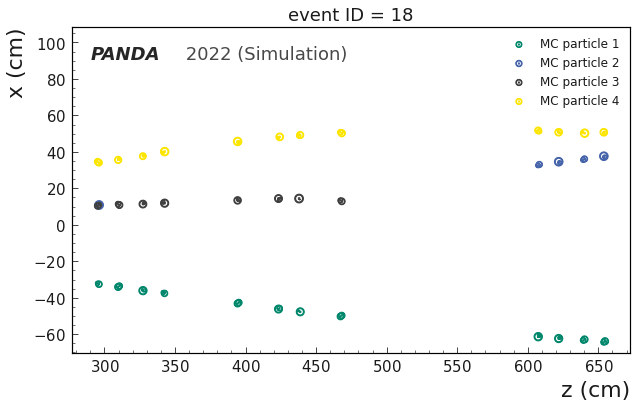

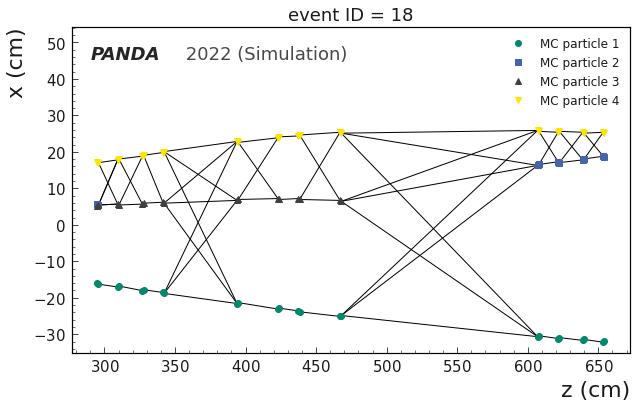

CPU times: user 1.43 s, sys: 261 ms, total: 1.69 s
Wall time: 1.4 s


In [8]:
%%time
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



# Prepare Training

In [9]:
torch.manual_seed(42)
device = torch.device('cpu')
hidden_size = 8
lr = 0.01
gamma = 0.7
epochs = 10
patience = 5
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}

In [10]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [11]:
model = InteractionNetwork(node_dim=4, edge_dim=3, hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
patience = 3

model.count_parameters()

InteractionNetwork(node_dim: 4, edge_dim: 3, hidden_size: 8)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     88     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     24     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     56     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     32     |
|  O.layers.4.bias   |     4      |
| R2.layers.0.weight |     88     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 544


# Training

In [12]:
results = train_model(train_loader, val_loader, test_loader, model, optimizer, scheduler, epochs=epochs, patience=patience)

  0%|                                                                                                            | 0/10 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.62s
Mean Train Batch Loss: 0.5762
TPR = 0.013605442176870748, TNR = 0.9856459330143541
diff= 0.2659, nbest_disc= 0.6900
mean best disc 0.680


 10%|██████████                                                                                          | 1/10 [00:01<00:09,  1.02s/it]


Test set: Average loss: 0.0471
, Accuracy: 0.8574

Validation loss decreased (inf --> 0.404401).  Saving model ...
Train Epoch: 2, epoch time: 0.57s
Mean Train Batch Loss: 0.3132
TPR = 0.7391304347826086, TNR = 0.7959183673469388
diff= 0.0364, nbest_disc= 0.7900
mean best disc 0.643


 20%|████████████████████                                                                                | 2/10 [00:01<00:07,  1.02it/s]


Test set: Average loss: 0.0210
, Accuracy: 0.9058

Validation loss decreased (0.404401 --> 0.284098).  Saving model ...
Train Epoch: 3, epoch time: 0.56s
Mean Train Batch Loss: 0.2811
TPR = 0.9739130434782609, TNR = 0.8738738738738738
diff= 0.1000, nbest_disc= 0.8000
mean best disc 0.739


 30%|██████████████████████████████                                                                      | 3/10 [00:02<00:06,  1.03it/s]


Test set: Average loss: 0.0306
, Accuracy: 0.9112

EarlyStopping counter: 1 out of 3
Train Epoch: 4, epoch time: 0.52s
Mean Train Batch Loss: 0.2887
TPR = 0.9197080291970803, TNR = 0.943502824858757
diff= 0.0019, nbest_disc= 0.7300
mean best disc 0.684


 40%|████████████████████████████████████████                                                            | 4/10 [00:03<00:05,  1.05it/s]


Test set: Average loss: 0.0287
, Accuracy: 0.9127

Validation loss decreased (0.284098 --> 0.253263).  Saving model ...
Train Epoch: 5, epoch time: 0.55s
Mean Train Batch Loss: 0.2434
TPR = 0.9595959595959596, TNR = 1.0
diff= 0.0042, nbest_disc= 0.4200
mean best disc 0.634


 50%|██████████████████████████████████████████████████                                                  | 5/10 [00:04<00:04,  1.06it/s]


Test set: Average loss: 0.0303
, Accuracy: 0.9177

Validation loss decreased (0.253263 --> 0.240442).  Saving model ...
Train Epoch: 6, epoch time: 0.51s
Mean Train Batch Loss: 0.2409
TPR = 0.84, TNR = 0.9130434782608695
diff= 0.0004, nbest_disc= 0.7500
mean best disc 0.556


 60%|████████████████████████████████████████████████████████████                                        | 6/10 [00:05<00:03,  1.06it/s]


Test set: Average loss: 0.0363
, Accuracy: 0.9197

Validation loss decreased (0.240442 --> 0.215574).  Saving model ...
Train Epoch: 7, epoch time: 0.57s
Mean Train Batch Loss: 0.2197
TPR = 0.7368421052631579, TNR = 0.9069767441860465
diff= 0.0021, nbest_disc= 0.6100
mean best disc 0.522


 70%|██████████████████████████████████████████████████████████████████████                              | 7/10 [00:06<00:02,  1.04it/s]


Test set: Average loss: 0.0099
, Accuracy: 0.9266

Validation loss decreased (0.215574 --> 0.197450).  Saving model ...
Train Epoch: 8, epoch time: 0.55s
Mean Train Batch Loss: 0.2071
TPR = 0.9696969696969697, TNR = 1.0
diff= 0.0021, nbest_disc= 0.4500
mean best disc 0.501


 80%|████████████████████████████████████████████████████████████████████████████████                    | 8/10 [00:07<00:01,  1.05it/s]


Test set: Average loss: 0.0181
, Accuracy: 0.9174

EarlyStopping counter: 1 out of 3
Train Epoch: 9, epoch time: 0.55s
Mean Train Batch Loss: 0.2076
TPR = 0.8350515463917526, TNR = 0.9711538461538461
diff= 0.0042, nbest_disc= 0.5400
mean best disc 0.565


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 9/10 [00:08<00:00,  1.06it/s]


Test set: Average loss: 0.0097
, Accuracy: 0.9235

EarlyStopping counter: 2 out of 3
Train Epoch: 10, epoch time: 0.54s
Mean Train Batch Loss: 0.2063
TPR = 0.7101449275362319, TNR = 0.8979591836734694
diff= 0.0021, nbest_disc= 0.6600
mean best disc 0.571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]


Test set: Average loss: 0.0055
, Accuracy: 0.9333

Validation loss decreased (0.197450 --> 0.191718).  Saving model ...


In [13]:
model, losses, accs, disc, test_losses, test_accs = results.trained

# Evaluate Training

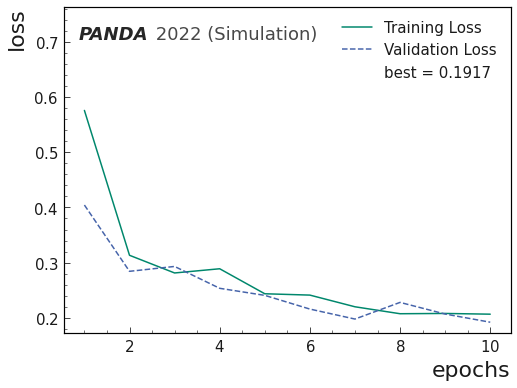

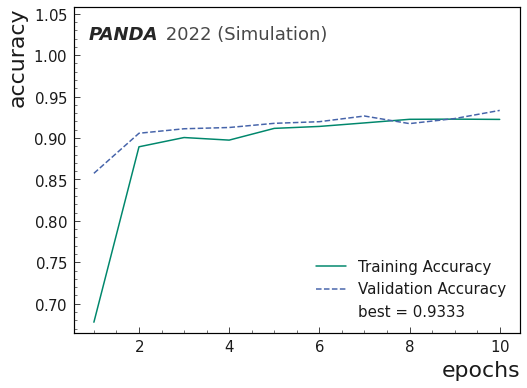

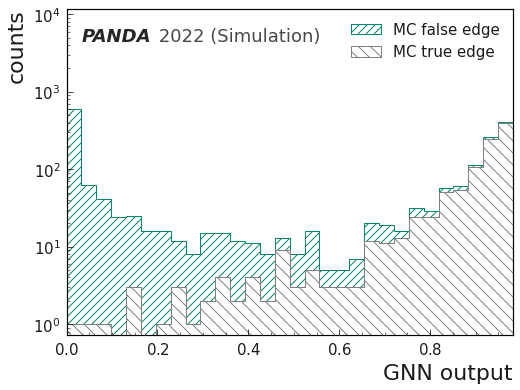

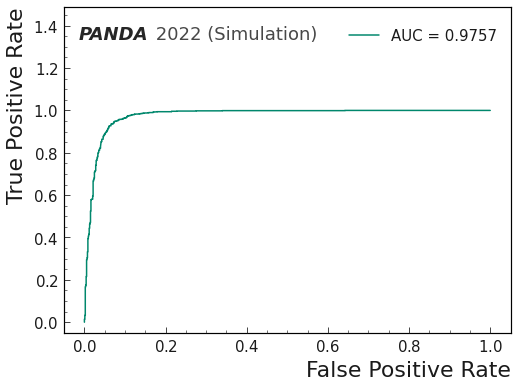

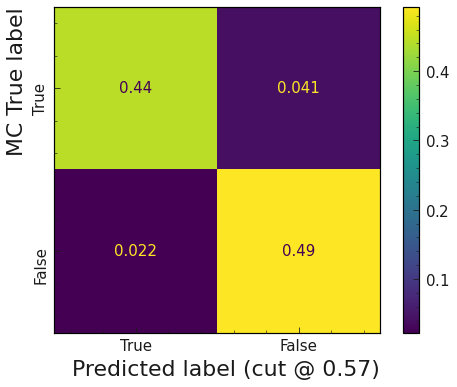

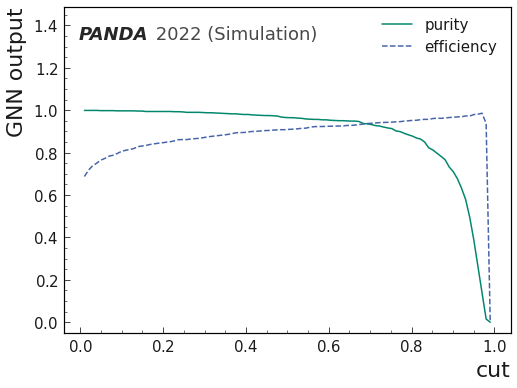

In [14]:
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, disc, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

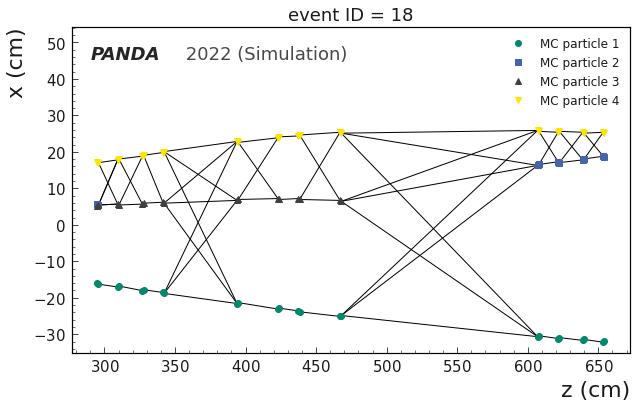

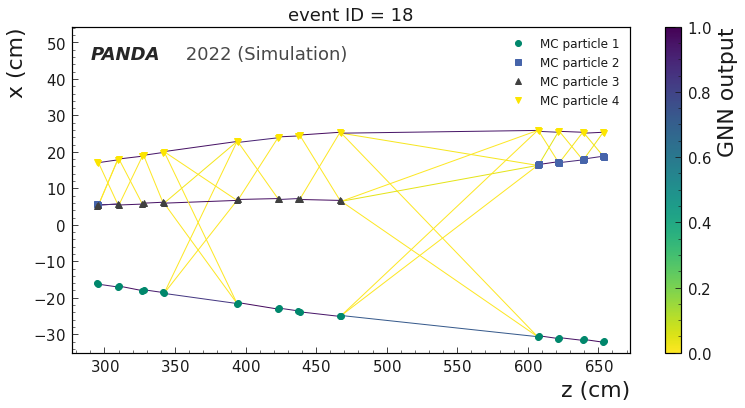

In [15]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)